# CIFAR-10 dataset on Convolutional Neural Network (CNN)

In this notebook, we will classify the images in the [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html) using a CNN.

The structure of this notebook is as such:

* Data pre-processing

* Hyper-parameter tuning

* Experiments



In [ ]:
# importing libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.model_selection import GridSearchCV
!pip install scikeras
from scikeras.wrappers import KerasClassifier

# Set the seed value for experiment reproducibility.
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

warnings.simplefilter('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data pre-processing

First we load the dataset. The input of the CNN takes the images in their original dimensions, so no need to vectorize the input. We also don't need to one-hot encode the output. 

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


We normalize the input.

In [ ]:
x_train = (x_train - np.mean(x_train, axis=0)) / np.std(x_train, axis=0)
x_test = (x_test - np.mean(x_test, axis=0)) / np.std(x_test, axis=0)

Let's take a look at the final shapes of the data.

In [ ]:
print("Shape of training data:")
print(x_train.shape)
print(y_train.shape, "\n")
print("Shape of test data:")
print(x_test.shape)
print(y_test.shape, "\n")
print("An example of a normalized instance:")
print(x_train[0])
print(f'shape: {x_train[0].shape} \n')
print("An example of a label:")
print(y_train[0])

Shape of training data:
(50000, 32, 32, 3)
(50000, 1) 

Shape of test data:
(10000, 32, 32, 3)
(10000, 1) 

An example of a normalized instance:
[[[-0.97682401 -1.01575822 -0.86457067]
  [-1.20290054 -1.24397271 -1.09116305]
  [-1.12196343 -1.23121589 -1.12774851]
  ...
  [ 0.37226975 -0.05993601 -0.30716213]
  [ 0.29723427 -0.1483418  -0.37591352]
  [ 0.24357708 -0.15787621 -0.36051491]]

 [[-1.5698109  -1.59760997 -1.39387218]
  [-1.79991445 -1.88484817 -1.64744766]
  [-1.56880617 -1.79174252 -1.66185562]
  ...
  [-0.09855519 -0.66409268 -0.96227293]
  [-0.14373515 -0.72217858 -1.01627722]
  [-0.09886808 -0.65922515 -0.92377691]]

 [[-1.45482436 -1.54821175 -1.37961682]
  [-1.58630684 -1.79258968 -1.64550579]
  [-1.14034845 -1.52843453 -1.55931244]
  ...
  [-0.15907907 -0.71348254 -1.01747988]
  [-0.12110123 -0.70263699 -1.00953845]
  [-0.27373108 -0.85187597 -1.1084575 ]]

 ...

 [[ 1.26721816  0.71031234 -0.27672181]
  [ 1.20986321  0.48109763 -1.21174062]
  [ 1.17926178  0.6313301

# The CNN model

Now let's build the CNN model. The model will have two
convolutional and two fully connected layers. The two fully connected layers both have 256 units. The activations in all layers are ReLU. Optimizer is ADAM. The model uses early stopping once the test accuracy does not improve after 10 epochs. 

Reference: https://www.tensorflow.org/tutorials/images/cnn 

In [ ]:
class CNN:

    def __init__(self, n_neurons=[32, 32], activation='relu', learning_rate=0.001, 
                 epochs=10, patience=10):
        self.n_neurons = n_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.patience= patience

    def make_model(self):
        model = models.Sequential()
        model.add(layers.Conv2D(self.n_neurons[0], (3, 3), 
                                activation=self.activation, input_shape=(32, 32, 3)))
        model.add(layers.Conv2D(self.n_neurons[1], (3, 3), 
                                activation=self.activation))
        model.add(layers.Flatten())
        model.add(layers.Dense(256, activation=self.activation))
        model.add(layers.Dense(256, activation=self.activation))
        model.add(layers.Dense(10))

        lr = self.learning_rate

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
        
        self.model = model

    def summary(self):
        self.model.summary()
    
    def train(self, x_train, y_train, x_test, y_test):

        earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="auto", patience=self.patience,
                                        restore_best_weights=True)

        self.history = self.model.fit(x_train, y_train, epochs=self.epochs, 
                                 validation_data=(x_test, y_test),
                                 callbacks=[earlystopping])
    
    def evaluate(self, x_test, y_test):
        plt.plot(self.history.history['accuracy'], label='training accuracy')
        plt.plot(self.history.history['val_accuracy'], label = 'test accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')

        test_loss, test_acc = self.model.evaluate(x_test,  y_test, verbose=2)

Let's test the CNN class with a smaller dataset with only 1000 instances.

In [ ]:
x_train_small = x_train[:1000]
y_train_small = y_train[:1000]
x_test_small = x_test[:1000]
y_test_small = y_test[:1000]

In [ ]:
CNN = CNN(epochs=50)
CNN.make_model()
CNN.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 flatten_12 (Flatten)        (None, 25088)             0         
                                                                 
 dense_36 (Dense)            (None, 256)               6422784   
                                                                 
 dense_37 (Dense)            (None, 256)               65792     
                                                                 
 dense_38 (Dense)            (None, 10)                2570      
                                                                 
Total params: 6,501,290
Trainable params: 6,501,290
N

In [ ]:
CNN.train(x_train_small, y_train_small, x_test_small, y_test_small)

Epoch 1/50
32/32 [==============================] - 10s 291ms/step - loss: 2.1797 - accuracy: 0.2420 - val_loss: 1.9408 - val_accuracy: 0.3100
Epoch 2/50
32/32 [==============================] - 6s 191ms/step - loss: 1.5958 - accuracy: 0.4300 - val_loss: 1.9298 - val_accuracy: 0.3070
Epoch 3/50
32/32 [==============================] - 8s 256ms/step - loss: 0.9950 - accuracy: 0.6620 - val_loss: 1.8926 - val_accuracy: 0.3740
Epoch 4/50
32/32 [==============================] - 6s 192ms/step - loss: 0.3448 - accuracy: 0.9070 - val_loss: 2.2914 - val_accuracy: 0.3670
Epoch 5/50
32/32 [==============================] - 7s 231ms/step - loss: 0.1032 - accuracy: 0.9810 - val_loss: 2.7298 - val_accuracy: 0.3910
Epoch 6/50
32/32 [==============================] - 7s 229ms/step - loss: 0.0362 - accuracy: 0.9930 - val_loss: 3.0305 - val_accuracy: 0.3770
Epoch 7/50
32/32 [==============================] - 8s 266ms/step - loss: 0.0082 - accuracy: 0.9990 - val_loss: 3.2521 - val_accuracy: 0.3850
Epoch

32/32 - 1s - loss: 3.9781 - accuracy: 0.4010 - 908ms/epoch - 28ms/step


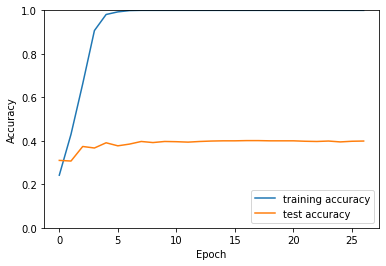

In [ ]:
CNN.evaluate(x_test_small, y_test_small)

The test accuracy is expectedly low.

# Hyper-parameter tuning

Now let's tune the hyperparameters of the CNN model. The hyperparamenters to be tuned are

* numbers of units in the two hidden layers
* learning rate.

We first define a Keras CNN model with the same architecture as the one defined in the CNN class above. Then we wrap the model with `KerasClassifier` from `scikeras.wrappers`  so we can use the grid search function in scikit-learn.

Reference: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ 


In [ ]:
def create_model(first_layer_nodes, second_layer_nodes):
    model = models.Sequential()
    model.add(layers.Conv2D(first_layer_nodes, (3, 3), activation='relu', 
                            input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(second_layer_nodes, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose = False, 
                        first_layer_nodes=[64,32,16], 
                        second_layer_nodes=[64,32,16])  

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]

param_grid = dict(first_layer_nodes=[64,32,16], second_layer_nodes=[64,32,16], 
                  optimizer__learning_rate=learn_rate)

# use 3-fold
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# use a smaller dataset to tune because of hardware limitations
grid_result = grid.fit(x_train[:10000], y_train[:10000])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.462502 using {'first_layer_nodes': 32, 'optimizer__learning_rate': 0.1, 'second_layer_nodes': 64}
0.437298 (0.017935) with: {'first_layer_nodes': 64, 'optimizer__learning_rate': 0.001, 'second_layer_nodes': 64}
0.406998 (0.025577) with: {'first_layer_nodes': 64, 'optimizer__learning_rate': 0.001, 'second_layer_nodes': 32}
0.421000 (0.002334) with: {'first_layer_nodes': 64, 'optimizer__learning_rate': 0.001, 'second_layer_nodes': 16}
0.417798 (0.013555) with: {'first_layer_nodes': 64, 'optimizer__learning_rate': 0.01, 'second_layer_nodes': 64}
0.392005 (0.035973) with: {'first_layer_nodes': 64, 'optimizer__learning_rate': 0.01, 'second_layer_nodes': 32}
0.423598 (0.018024) with: {'first_layer_nodes': 64, 'optimizer__learning_rate': 0.01, 'second_layer_nodes': 16}
0.416699 (0.009647) with: {'first_layer_nodes': 64, 'optimizer__learning_rate': 0.1, 'second_layer_nodes': 64}
0.413901 (0.005504) with: {'first_layer_nodes': 64, 'optimizer__learning_rate': 0.1, 'second_layer_nodes': 3

# Experiments

Based on the result of the hyperparamter tuning, let's test on models with 32 units in the first convolutional layer and 64 units in the second, and let's vary the learining rates.

## Experiment 1: (32, 64, 0.001)

First, let's try the default learning rate of ADAM in Keras, 0.001.

In [ ]:
model1 = CNN(n_neurons=[32, 64], learning_rate=0.001, epochs=200)
model1.make_model()
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               12845312  
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 10)                2570      
                                                                 
Total params: 12,933,066
Trainable params: 12,933,066


In [ ]:
model1.train(x_train, y_train, x_test, y_test)

Epoch 1/200
1563/1563 [==============================] - 619s 395ms/step - loss: 1.2608 - accuracy: 0.5526 - val_loss: 1.0305 - val_accuracy: 0.6425
Epoch 2/200
1563/1563 [==============================] - 591s 378ms/step - loss: 0.7745 - accuracy: 0.7295 - val_loss: 1.0225 - val_accuracy: 0.6556
Epoch 3/200
1563/1563 [==============================] - 604s 386ms/step - loss: 0.4101 - accuracy: 0.8585 - val_loss: 1.1723 - val_accuracy: 0.6536
Epoch 4/200
1563/1563 [==============================] - 613s 392ms/step - loss: 0.1873 - accuracy: 0.9356 - val_loss: 1.7192 - val_accuracy: 0.6404
Epoch 5/200
1563/1563 [==============================] - 612s 391ms/step - loss: 0.1145 - accuracy: 0.9629 - val_loss: 2.0744 - val_accuracy: 0.6267
Epoch 6/200
1563/1563 [==============================] - 595s 381ms/step - loss: 0.0874 - accuracy: 0.9722 - val_loss: 2.0701 - val_accuracy: 0.6491
Epoch 7/200
1563/1563 [==============================] - 601s 384ms/step - loss: 0.0790 - accuracy: 0.9744

313/313 - 18s - loss: 1.0225 - accuracy: 0.6556 - 18s/epoch - 57ms/step


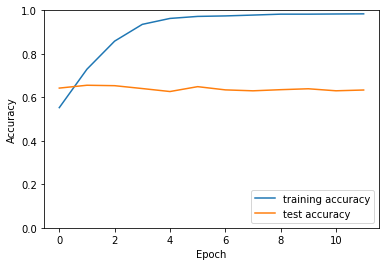

In [ ]:
model1.evaluate(x_test, y_test)

## Experiment 2: (32, 64, 0.1)

Let's try learning rate 0.1, the optimal learning rate based on the hyperparameter tuning.

In [ ]:
model2 = CNN(n_neurons=[32, 64], learning_rate=0.1, epochs=200, patience=2)
model2.make_model()
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 flatten_6 (Flatten)         (None, 50176)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               12845312  
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dense_20 (Dense)            (None, 10)                2570      
                                                                 
Total params: 12,933,066
Trainable params: 12,933,066


In [ ]:
model2.train(x_train, y_train, x_test, y_test)

Epoch 1/200
1563/1563 [==============================] - 645s 411ms/step - loss: 486.4457 - accuracy: 0.1010 - val_loss: 2.3156 - val_accuracy: 0.1000
Epoch 2/200
1563/1563 [==============================] - 611s 391ms/step - loss: 2.3164 - accuracy: 0.0993 - val_loss: 2.3106 - val_accuracy: 0.1000
Epoch 3/200
1563/1563 [==============================] - 639s 409ms/step - loss: 2.3162 - accuracy: 0.0983 - val_loss: 2.3058 - val_accuracy: 0.1000


It is clear that the weights did not converge. The learning rate 0.1, although tested to be the best on a smaller dataset, is too large for a bigger dataset. 

## Experiment 3: (32, 64, 0.01)

Below, we test the learning rate 0.01.

In [ ]:
model3 = CNN(n_neurons=[32, 64], learning_rate=0.01, epochs=200, patience=2)
model3.make_model()
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 flatten_7 (Flatten)         (None, 50176)             0         
                                                                 
 dense_21 (Dense)            (None, 256)               12845312  
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dense_23 (Dense)            (None, 10)                2570      
                                                                 
Total params: 12,933,066
Trainable params: 12,933,066


In [ ]:
model3.train(x_train, y_train, x_test, y_test)

Epoch 1/200
1563/1563 [==============================] - 679s 433ms/step - loss: 2.4299 - accuracy: 0.0992 - val_loss: 2.3042 - val_accuracy: 0.1000
Epoch 2/200
1563/1563 [==============================] - 610s 391ms/step - loss: 2.3042 - accuracy: 0.0968 - val_loss: 2.3037 - val_accuracy: 0.1000
Epoch 3/200
1563/1563 [==============================] - 644s 412ms/step - loss: 2.3042 - accuracy: 0.0959 - val_loss: 2.3038 - val_accuracy: 0.1000


The weights were not converging. 

In conclusion, the best performance of our CNN model is with 32 units in the first convolutional layer and 64 units in the second. The learning rate used is 0.001. The model has a loss of 1.0225 and achieves accuracy 0.6556.

## Extra experiments

Below are some extra experiments we did: CNN with 16 units in the first layer and 32 units in the second. The learning rates tested are 0.001, 0.01, and 0.1. The best performance has an accuracy of 0.6475. 

In [ ]:
model = CNN(n_neurons=[16, 32], learning_rate=0.001, epochs=200)
model.make_model()
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 flatten_19 (Flatten)        (None, 25088)             0         
                                                                 
 dense_57 (Dense)            (None, 256)               6422784   
                                                                 
 dense_58 (Dense)            (None, 256)               65792     
                                                                 
 dense_59 (Dense)            (None, 10)                2570      
                                                                 
Total params: 6,496,234
Trainable params: 6,496,234
N

In [ ]:
model.train(x_train, y_train, x_test, y_test)

Epoch 1/200
1563/1563 [==============================] - 270s 172ms/step - loss: 1.3099 - accuracy: 0.5334 - val_loss: 1.0584 - val_accuracy: 0.6262
Epoch 2/200
1563/1563 [==============================] - 244s 156ms/step - loss: 0.8283 - accuracy: 0.7098 - val_loss: 1.0647 - val_accuracy: 0.6439
Epoch 3/200
1563/1563 [==============================] - 262s 168ms/step - loss: 0.4851 - accuracy: 0.8314 - val_loss: 1.1782 - val_accuracy: 0.6475
Epoch 4/200
1563/1563 [==============================] - 243s 155ms/step - loss: 0.2310 - accuracy: 0.9217 - val_loss: 1.5339 - val_accuracy: 0.6314
Epoch 5/200
1563/1563 [==============================] - 243s 156ms/step - loss: 0.1424 - accuracy: 0.9528 - val_loss: 1.7716 - val_accuracy: 0.6288
Epoch 6/200
1563/1563 [==============================] - 238s 153ms/step - loss: 0.1020 - accuracy: 0.9658 - val_loss: 2.0902 - val_accuracy: 0.6166
Epoch 7/200
1563/1563 [==============================] - 243s 156ms/step - loss: 0.0850 - accuracy: 0.9719

313/313 - 10s - loss: 1.1782 - accuracy: 0.6475 - 10s/epoch - 32ms/step


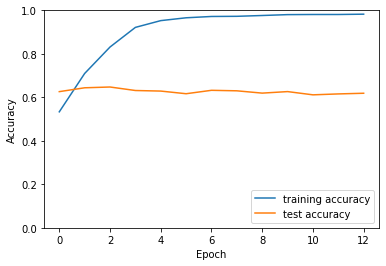

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
model = CNN(n_neurons=[16, 32], learning_rate=0.1, epochs=200)
model.make_model()
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 flatten_20 (Flatten)        (None, 25088)             0         
                                                                 
 dense_60 (Dense)            (None, 256)               6422784   
                                                                 
 dense_61 (Dense)            (None, 256)               65792     
                                                                 
 dense_62 (Dense)            (None, 10)                2570      
                                                                 
Total params: 6,496,234
Trainable params: 6,496,234
N

In [ ]:
model2.train(x_train, y_train, x_test, y_test)

Epoch 1/200
1563/1563 [==============================] - 243s 154ms/step - loss: 1.3173 - accuracy: 0.5293 - val_loss: 1.0903 - val_accuracy: 0.6167
Epoch 2/200
1563/1563 [==============================] - 241s 154ms/step - loss: 0.8443 - accuracy: 0.7062 - val_loss: 1.0354 - val_accuracy: 0.6458
Epoch 3/200
1563/1563 [==============================] - 242s 155ms/step - loss: 0.5078 - accuracy: 0.8231 - val_loss: 1.1698 - val_accuracy: 0.6460
Epoch 4/200
1563/1563 [==============================] - 241s 154ms/step - loss: 0.2389 - accuracy: 0.9175 - val_loss: 1.5610 - val_accuracy: 0.6278
Epoch 5/200
1563/1563 [==============================] - 245s 157ms/step - loss: 0.1421 - accuracy: 0.9518 - val_loss: 1.9570 - val_accuracy: 0.6292
Epoch 6/200
1563/1563 [==============================] - 251s 161ms/step - loss: 0.1010 - accuracy: 0.9661 - val_loss: 2.1029 - val_accuracy: 0.6213
Epoch 7/200
1563/1563 [==============================] - 250s 160ms/step - loss: 0.0905 - accuracy: 0.9698

313/313 - 10s - loss: 1.1698 - accuracy: 0.6460 - 10s/epoch - 32ms/step


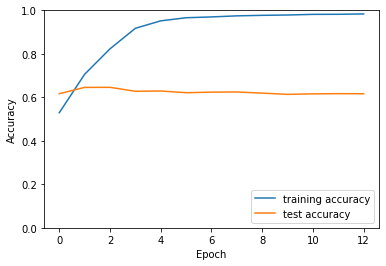

In [ ]:
model2.evaluate(x_test, y_test)

In [ ]:
model3 = CNN(n_neurons=[16, 32], learning_rate=0.01, epochs=200)
model3.make_model()
model3.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 conv2d_43 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 flatten_21 (Flatten)        (None, 25088)             0         
                                                                 
 dense_63 (Dense)            (None, 256)               6422784   
                                                                 
 dense_64 (Dense)            (None, 256)               65792     
                                                                 
 dense_65 (Dense)            (None, 10)                2570      
                                                                 
Total params: 6,496,234
Trainable params: 6,496,234
N

In [ ]:
model3.train(x_train, y_train, x_test, y_test)

Epoch 1/200
1563/1563 [==============================] - 251s 160ms/step - loss: 2.3404 - accuracy: 0.0996 - val_loss: 2.3042 - val_accuracy: 0.1000
Epoch 2/200
1563/1563 [==============================] - 238s 153ms/step - loss: 2.3042 - accuracy: 0.0968 - val_loss: 2.3037 - val_accuracy: 0.1000
Epoch 3/200
1563/1563 [==============================] - 252s 161ms/step - loss: 2.3042 - accuracy: 0.0961 - val_loss: 2.3038 - val_accuracy: 0.1000
Epoch 4/200
1563/1563 [==============================] - 250s 160ms/step - loss: 2.3039 - accuracy: 0.1002 - val_loss: 2.3043 - val_accuracy: 0.1000
Epoch 5/200
1563/1563 [==============================] - 246s 158ms/step - loss: 2.3040 - accuracy: 0.0992 - val_loss: 2.3045 - val_accuracy: 0.1000
Epoch 6/200
1563/1563 [==============================] - 247s 158ms/step - loss: 2.3040 - accuracy: 0.0987 - val_loss: 2.3039 - val_accuracy: 0.1000
Epoch 7/200
1563/1563 [==============================] - 240s 154ms/step - loss: 2.3039 - accuracy: 0.0995

313/313 - 8s - loss: 2.3042 - accuracy: 0.1000 - 8s/epoch - 24ms/step


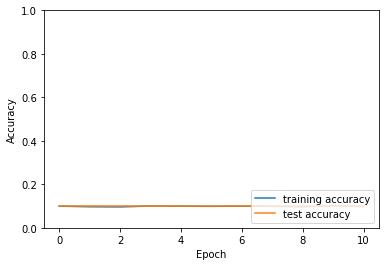

In [ ]:
model3.evaluate(x_test, y_test)